In [ ]:
# multivariate output stacked lstm example
from numpy import array
from numpy import hstack
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Embedding
from keras.layers import Dense
from keras.optimizers import Adam,SGD
from keras.optimizers import RMSprop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import AlphaDropout
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed,Conv1D,MaxPooling1D,Flatten
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import LeakyReLU
from keras.constraints import maxnorm
from tqdm import tqdm_notebook, tqdm
from collections import deque

In [ ]:
%pip install yfinance

     |████████████████████████████████| 5.5MB 19.4MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=0c05ade88f721f4929cfe2c851d3f85a16a34b11ae293dd4654c179783ff4919
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf
ticker = 'AMZN'
index = yf.Ticker(ticker)

# get 6 year 2013-2019 historical market data to train 
df_A = index.history(start='2013-01-01', end= '2019-12-30', actions=False)

In [ ]:
#!unzip 'AMZN.zip' -d AMZN

Archive:  AMZN.zip
   creating: AMZN/content/my_model/
   creating: AMZN/content/my_model/.ipynb_checkpoints/
   creating: AMZN/content/my_model/variables/
  inflating: AMZN/content/my_model/variables/variables.data-00000-of-00001  
  inflating: AMZN/content/my_model/variables/variables.index  
   creating: AMZN/content/my_model/assets/
  inflating: AMZN/content/my_model/saved_model.pb  


In [ ]:
#model = tf.keras.models.load_model('my_model')
#NVDA SP500 NFLX DJI AMZN-> GOOG

In [ ]:
lookback_days=30
forward_days =3

In [ ]:
%pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

     |████████████████████████████████| 133kB 21.2MB/s 


In [ ]:
# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()
tweets_df2 = pd.read_csv('AMZN.csv')
columns = ['Datetime', 'Tweet Id', 'Text']
news = pd.DataFrame(tweets_df2, columns=columns)
#news.Datetime = news.Datetime.apply(lambda x: x.date())
news['Date'] = pd.to_datetime(news['Datetime'].astype(str).str[:10], errors='coerce')
news['Text'] = news['Text'].astype(str)
scores = news['Text'].apply(analyzer.polarity_scores).tolist()

df_scores = pd.DataFrame(scores)
news = news.join(df_scores, rsuffix='_right')

news.set_index = pd.to_datetime(news['Date'])
news = news.groupby(
    [news['Date']]
)['compound','neg','neu','pos'].mean()

In [ ]:
news.tail(5)

,Datetime,Tweet Id,Text,Date,neg,neu,pos,compound
95653,2021-02-28 07:18:57+00:00,1365924434113032196,@TheLioncom It's the best broker for people th...,2021-02-28,0.000,0.792,0.208,0.6705
95654,2021-02-28 06:43:42+00:00,1365915565425008640,@ArbiterValue @AaronDayAtlas @Fxhedgers $AAPL ...,2021-02-28,0.000,0.880,0.120,0.3818
95655,2021-02-28 04:49:46+00:00,1365886891191533570,@ArbiterValue @AaronDayAtlas @Fxhedgers Wym Bu...,2021-02-28,0.000,1.000,0.000,0.0000
95656,2021-02-28 03:47:41+00:00,1365871266893164559,@Frankie42033653 @Reuters Berkshire invested i...,2021-02-28,0.000,0.945,0.055,0.4215
95657,2021-02-28 01:22:04+00:00,1365834621880049666,@c64f7e94 @jchervinsky @TheStalwart Youre miss...,2021-02-28,0.084,0.881,0.034,-0.3818


In [ ]:
news = pd.read_csv('amzn.csv')

In [ ]:
def get_technical_indicators(dataset):
    # Create 7 and 30 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7, min_periods = 1).mean()
    dataset['ma26'] = dataset['Close'].rolling(window=26, min_periods = 1).mean()

    dataset['ma7_open'] = dataset['Open'].rolling(window=7, min_periods = 1).mean()
    dataset['ma26_open'] = dataset['Open'].rolling(window=26, min_periods = 1).mean()
    
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])
# Create Bollinger Bands
    dataset['20sd'] = dataset['Close'].rolling(window=20, min_periods = 1).std()
    dataset['20sd'] = dataset['20sd'].fillna(method='backfill').dropna()
    dataset['upper_band'] = dataset['ma26'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma26'] - (dataset['20sd']*2)

    dataset['Close_lag1'] = dataset['Close'] .shift(1)
    #dataset['Close_lag1'] = dataset['Close_lag1'].fillna(method='backfill').dropna()
    dataset['Close_lag2'] = dataset['Close'] .shift(2)
    #dataset['Close_lag2'] = dataset['Close_lag2'].fillna(method='backfill').dropna()
    dataset['Close_lag3'] = dataset['Close'] .shift(3)
    #dataset['Close_lag3'] = dataset['Close_lag3'].fillna(method='backfill').dropna()
    dataset['Close_lag4'] = dataset['Close'] .shift(4)
    #dataset['Close_lag4'] = dataset['Close_lag4'].fillna(method='backfill').dropna()
    dataset['Close_lag5'] = dataset['Close'] .shift(5)
    #dataset['Close_lag5'] = dataset['Close_lag5'].fillna(method='backfill').dropna()
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    dataset['Close_ahead1'] = dataset['Close'] .shift(-1)
    dataset['Close_ahead2'] = dataset['Close'] .shift(-2)
    dataset['Close_ahead3'] = dataset['Close'] .shift(-3)

    dataset['ClosePerChg1'] = ((dataset['Close_ahead1'] - dataset['Close'])/dataset['Close'])   
    dataset['ClosePerChg2'] = ((dataset['Close_ahead2'] - dataset['Close'])/dataset['Close']) 
    dataset['ClosePerChg3'] = ((dataset['Close_ahead3'] - dataset['Close'])/dataset['Close']) 

    dataset['Open_ahead1'] = dataset['Open'] .shift(-1)
    dataset['Open_ahead2'] = dataset['Open'] .shift(-2)
    dataset['Open_ahead3'] = dataset['Open'] .shift(-3)

    dataset['OpenPerChg1'] = ((dataset['Open_ahead1'] - dataset['Open'])/dataset['Open'])  
    dataset['OpenPerChg2'] = ((dataset['Open_ahead2'] - dataset['Open'])/dataset['Open']) 
    dataset['OpenPerChg3'] = ((dataset['Open_ahead3'] - dataset['Open'])/dataset['Open']) 
    # Create Momentum
    #dataset['momentum'] = dataset['Close']-1
    
    return dataset

In [ ]:
df_A_ti = get_technical_indicators(df_A)

In [ ]:
df_A_ti = df_A_ti.merge(news, how ='left' , on = 'Date')

df_A_ti.neg = df_A_ti.neg.fillna(0.5)
df_A_ti.neu = df_A_ti.neu.fillna(0.5)
df_A_ti.pos = df_A_ti.pos.fillna(0.5)

In [ ]:
df_A_ti

,Open,High,Low,Close,Volume,ma7,ma26,ma7_open,ma26_open,26ema,12ema,MACD,20sd,upper_band,lower_band,Close_lag1,Close_lag2,Close_lag3,Close_lag4,Close_lag5,ema,Close_ahead1,Close_ahead2,Close_ahead3,ClosePerChg1,ClosePerChg2,ClosePerChg3,Open_ahead1,Open_ahead2,Open_ahead3,OpenPerChg1,OpenPerChg2,OpenPerChg3,compound,neg,neu,pos
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-02,13412.500000,13412.500000,13412.500000,13412.500000,0,13412.500000,13412.500000,13412.500000,13412.500000,13412.500000,13412.500000,0.000000,14.919677,13442.339354,13382.660646,NaN,NaN,NaN,NaN,NaN,13412.500000,13391.400391,13435.200195,13384.299805,-0.001573,0.001692,-0.002103,13391.400391,13435.200195,13384.299805,-0.001573,0.001692,-0.002103,0.162100,0.028129,0.870143,0.101714
2013-01-03,13391.400391,13391.400391,13391.400391,13391.400391,0,13401.950195,13401.950195,13401.950195,13401.950195,13401.544434,13401.071045,-0.473389,14.919677,13431.789549,13372.110842,13412.500000,NaN,NaN,NaN,NaN,13396.675293,13435.200195,13384.299805,13328.799805,0.003271,-0.000530,-0.004675,13435.200195,13384.299805,13328.799805,0.003271,-0.000530,-0.004675,0.335328,0.020262,0.792934,0.186787
2013-01-04,13435.200195,13435.200195,13435.200195,13435.200195,0,13413.033529,13413.033529,13413.033529,13413.033529,13413.636622,13414.391660,0.755038,21.904776,13456.843081,13369.223977,13391.400391,13412.500000,NaN,NaN,NaN,13423.346379,13384.299805,13328.799805,13390.500000,-0.003789,-0.007920,-0.003327,13384.299805,13328.799805,13390.500000,-0.003789,-0.007920,-0.003327,0.158577,0.054535,0.775837,0.169628
2013-01-07,13384.299805,13384.299805,13384.299805,13384.299805,0,13405.850098,13405.850098,13405.850098,13405.850098,13405.435330,13404.892837,-0.542492,22.940928,13451.731955,13359.968241,13435.200195,13391.400391,13412.500000,NaN,NaN,13396.989941,13328.799805,13390.500000,13471.200195,-0.004147,0.000463,0.006493,13328.799805,13390.500000,13471.200195,-0.004147,0.000463,0.006493,0.052937,0.033815,0.911457,0.054753
2013-01-08,13328.799805,13328.799805,13328.799805,13328.799805,0,13390.440039,13390.440039,13390.440039,13390.440039,13387.663236,13384.218632,-3.444603,39.775170,13469.990380,13310.889698,13384.299805,13435.200195,13391.400391,13412.500000,NaN,13351.341999,13390.500000,13471.200195,13488.400391,0.004629,0.010684,0.011974,13390.500000,13471.200195,13488.400391,0.004629,0.010684,0.011974,0.152150,0.015444,0.894067,0.090500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-31,24815.000000,24815.000000,24815.000000,24815.000000,0,25330.271484,25877.969351,25330.271484,25877.969351,25701.783945,25432.001861,-269.782084,411.548818,26701.066988,25054.871714,25169.900391,25126.400391,25347.800781,25585.699219,25490.500000,24939.624986,24819.800781,25332.199219,25539.599609,0.000193,0.020842,0.029200,24819.800781,25332.199219,25539.599609,0.000193,0.020842,0.029200,0.162745,0.030911,0.871386,0.097673
2019-06-03,24819.800781,24819.800781,24819.800781,24819.800781,0,25193.585938,25809.615535,25193.585938,25809.615535,25636.451859,25337.817079,-298.634779,406.756616,26623.128766,24996.102304,24815.000000,25169.900391,25126.400391,25347.800781,25585.699219,24859.742183,25332.199219,25539.599609,25983.900391,0.020645,0.029001,0.046902,25332.199219,25539.599609,25983.900391,0.020645,0.029001,0.046902,0.277552,0.031396,0.862515,0.106099
2019-06-04,25332.199219,25332.199219,25332.199219,25332.199219,0,25170.971540,25766.157828,25170.971540,25766.157828,25613.914626,25336.952793,-276.961833,358.860582,26483.878991,25048.436664,24819.800781,24815.000000,25169.900391,25126.400391,25347.800781,25174.713540,25539.599609,25983.900391,NaN,0.008187,0.025726,NaN,25539.599609,25983.900391,NaN,0.008187,0.025726,NaN,0.259014,0.030485,0.851307,0.118208


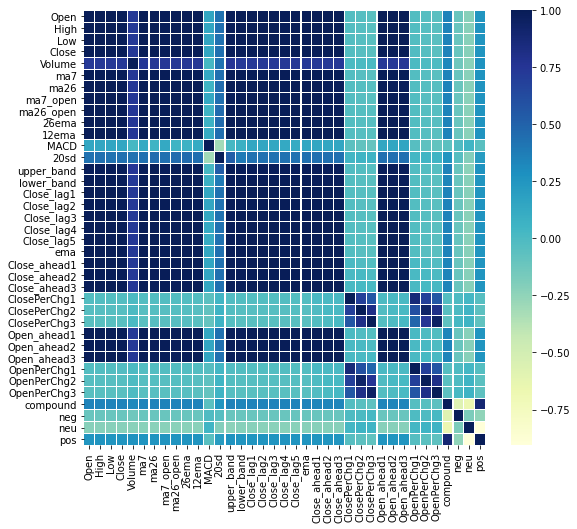

In [ ]:
import seaborn as sns 
from scipy.stats import norm 

#df_A_ti = get_technical_indicators(df_A)
#df_A_ti = df_A_ti.dropna()

corrmat = df_A_ti.corr() 
  
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

In [ ]:
#df_A_ti = get_technical_indicators(df_A)
#df_A_ti = df_A_ti.dropna()
#df_A_ti = df_A_ti[5:]
#df_A_ti = df_A_ti.fillna(method='backfill')
df_A_ti = df_A_ti.fillna(method='backfill')
df_A_ti = df_A_ti.dropna()
df_A_y = df_A_ti.copy()

#df_A_y['Per'] = (df_A_y['Close_lag1'] - df_A_y['Close'])/ df_A_y['Close_lag1'] )*100
df_A_y = df_A_y[['OpenPerChg1','ClosePerChg1','OpenPerChg2','ClosePerChg2','OpenPerChg3','ClosePerChg3']]
#df_A_ti = df_A_ti[5:]
df_A_ti = df_A_ti[['Open','Close','High', 'Low','Volume','20sd','MACD','neg','neu','pos']]
#,'Close_lag1','Close_lag2','Close_lag3','Close_lag4','Close_lag5'
#,'Adj Close','VIX_Open','VIX_High','VIX_Low','VIX_Close','VIX_Adj Close'
 #,'VIX_20sd','upper_band','lower_band']]#,'VIX_Open','VIX_High','VIX_Low','VIX_Close']]


In [ ]:
df_A_ti.isna().any()
df_A_y.isna().any()

OpenPerChg1     False
ClosePerChg1    False
OpenPerChg2     False
ClosePerChg2    False
OpenPerChg3     False
ClosePerChg3    False
dtype: bool

In [ ]:
#from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#plot_acf(df_A_ti['Close'], lags=50)
#plot_pacf(df_A_ti['Close'], lags=50)

In [ ]:
df_A_y

,OpenPerChg1,ClosePerChg1,OpenPerChg2,ClosePerChg2,OpenPerChg3,ClosePerChg3
Date,,,,,,
2013-01-02,-0.001573,-0.001573,0.001692,0.001692,-0.002103,-0.002103
2013-01-03,0.003271,0.003271,-0.000530,-0.000530,-0.004675,-0.004675
2013-01-04,-0.003789,-0.003789,-0.007920,-0.007920,-0.003327,-0.003327
2013-01-07,-0.004147,-0.004147,0.000463,0.000463,0.006493,0.006493
2013-01-08,0.004629,0.004629,0.010684,0.010684,0.011974,0.011974
...,...,...,...,...,...,...
2019-05-28,-0.008735,-0.008735,-0.007018,-0.007018,-0.021020,-0.021020
2019-05-29,0.001731,0.001731,-0.012393,-0.012393,-0.012202,-0.012202
2019-05-30,-0.014100,-0.014100,-0.013909,-0.013909,0.006448,0.006448


In [ ]:
args = df_A_ti.values.reshape(df_A_ti.shape[0],10)
args_y = df_A_y.values.reshape(df_A_y.shape[0],6)

In [ ]:
in_seq1 = args
in_seq1_y= args_y

In [ ]:
#x_scaler = MinMaxScaler().fit(args)
#X= x_scaler.transform(args)
print(in_seq1.shape)
print(in_seq1_y.shape)

(1611, 10)
(1611, 6)


In [ ]:
division = int(len(in_seq1) *8/10)

data_train = in_seq1[:division]
data_test = in_seq1[(division-lookback_days):]

data_train_y= in_seq1_y[:division]
data_test_y = in_seq1_y[(division-lookback_days):]

In [ ]:
def split_sequences(sequences, sequences_y,  n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences_y[end_ix-1:end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
X_train,y_train = split_sequences(data_train, data_train_y, lookback_days, forward_days)

In [ ]:
y_train.shape

(1259, 1, 6)

In [ ]:
X_features = X_train.shape[2]
y_features = y_train.shape[2]

In [ ]:
X_train=X_train.reshape(X_train.shape[0],lookback_days*X_features)
y_train=y_train.reshape(y_train.shape[0],y_features)

In [ ]:
X_train.shape

(1259, 300)

In [ ]:
x_scaler = MinMaxScaler()#.fit(X_train)
#x_scaler = RobustScaler(quantile_range = (0.05,0.95))
#x_scaler.fit(X_train)
#X_train = x_scaler.transform(X_train)

In [ ]:
smoothing_window_size = 500
for di in range(0,1000,smoothing_window_size):
    x_scaler.fit(X_train[di:di+smoothing_window_size,:])
    X_train[di:di+smoothing_window_size,:] = x_scaler.transform(X_train[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
x_scaler.fit(X_train[di+smoothing_window_size:,:])
X_train[di+smoothing_window_size:,:] = x_scaler.transform(X_train[di+smoothing_window_size:,:])

In [ ]:
y_scaler = MinMaxScaler(feature_range=(0, 1))#.fit(y_train)
#y_scaler = RobustScaler(quantile_range = (0.05,0.95))
#y_scaler.fit(y_train)
#y_train = y_scaler.transform(y_train)

In [ ]:
# smoothing_window_size = 500
# for di in range(0,1000,smoothing_window_size):
#     y_scaler.fit(y_train[di:di+smoothing_window_size,:])
#     y_train[di:di+smoothing_window_size,:] = y_scaler.transform(y_train[di:di+smoothing_window_size,:])

# # You normalize the last bit of remaining data
# y_scaler.fit(y_train[di+smoothing_window_size:,:])
# y_train[di+smoothing_window_size:,:] = y_scaler.transform(y_train[di+smoothing_window_size:,:])

In [ ]:
#y_scaler = StandardScaler()
y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)

<function matplotlib.pyplot.show>

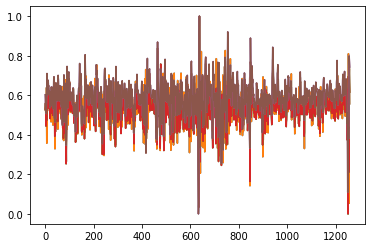

In [ ]:
#plt.plot(X_train)
plt.plot(y_train)
plt.show

In [ ]:
X_train = X_train.reshape(X_train.shape[0], lookback_days, X_features)
#y_train = y_train.reshape(y_train.shape[0], forward_days,y_features )

# Attention & Loss Function

In [ ]:
from tensorflow.keras import backend as K
class attention(tf.keras.layers.Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()
        
    def build(self, input_shape):
        
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")
        
        super(attention,self).build(input_shape)
        
    def call(self, x):
        
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        
        if self.return_sequences:
            return output
        
        return K.sum(output, axis=1)

    # def get_config(self):
    #     config = super().get_config().copy()
    #     config.update({
    #         'return_sequences': self.return_sequences 
    #     })
    #     return config

In [ ]:
def customLoss(ytrue,ypred):  
    diff = ypred - ytrue
    upperband = K.less(tf.cast(ytrue, dtype=tf.float32, name=None),tf.constant(0.6))
    
    upperband = K.cast(upperband, K.floatx()) #1 for lower, 0 for greater
    # print(upper
    p_upperband = K.less(tf.cast(ypred, dtype=tf.float32, name=None),tf.constant(0.6))
    
    p_upperband = K.cast(p_upperband, K.floatx()) #1 for lower, 0 for greater
    lowerband = K.greater(tf.cast(ytrue, dtype=tf.float32, name=None),tf.constant(0.2))
    lowerband = K.cast(lowerband, K.floatx()) #0 for lower, 1 for greater
    
    p_lowerband = K.greater(tf.cast(ypred, dtype=tf.float32, name=None),tf.constant(0.2))
    p_lowerband = K.cast(p_lowerband, K.floatx()) #0 for lower, 1 for greater

    ub_check = K.not_equal(upperband,p_upperband)
    ub_check = K.cast(ub_check, K.floatx())
    ub_check = ub_check + 1
    lb_check = K.not_equal(lowerband,p_lowerband)
    lb_check = K.cast(lb_check, K.floatx())
    lb_check = lb_check + 1
    band = K.equal(upperband,lowerband)
    band = K.cast(band, K.floatx())
    band = band + 1                 #1 for lower, 2 for greater
    greater = K.greater(tf.abs(diff),tf.constant(0.3))
    greater = K.cast(greater, K.floatx()) #0 for lower, 1 for greater
    greater = greater + 1                 #1 for lower, 2 for greater

    #use some kind of loss here, such as mse or mae, or pick one from keras
    #using mse:
    return (ub_check * lb_check * band * greater * K.square(diff))

# Model

In [ ]:
model = Sequential()
model.add((Conv1D(filters=32, kernel_size=5, activation='relu',
                                 input_shape=(30,10))))
# #model.add((MaxPooling1D(pool_size=2)))
# #model.add((Conv1D(filters=16, kernel_size=5, activation='relu')))
model.add((MaxPooling1D(pool_size=2)))
#model.add((Flatten()))A
model.add(Bidirectional(LSTM(100, return_sequences=True,#input_shape=(30,7),
              activation='tanh', recurrent_activation='hard_sigmoid',kernel_initializer='random_uniform')))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=True,
              activation='relu', recurrent_activation='hard_sigmoid',kernel_initializer='random_uniform')))
model.add(Dropout(0.5))

model.add(attention(return_sequences=False))
model.add((Dense(6)))
opt = Adam(lr=0.001)
model = tf.keras.models.load_model('AMZN/content/my_model', custom_objects={'customLoss':customLoss})
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',  patience=30)
#mc = tf.keras.callbacks.ModelCheckpoint( 'model.h5' ,monitor='val_loss', mode='min',  save_best_only=True )
model.compile(optimizer=opt, loss=[customLoss], metrics=[customLoss,'mse','mae','mape'])

In [ ]:
batch_size = 32
model.fit(np.asarray(X_train).astype(np.float32), np.asarray(y_train).astype(np.float32), epochs=150, verbose=1 , shuffle=True,
      callbacks=[es], batch_size=batch_size, validation_split=0.2)

Epoch 1/150
32/32 [==============================] - 11s 177ms/step - loss: 1.1223 - customLoss: 1.1223 - mse: 0.1511 - mae: 0.3289 - mape: 35939.6033 - val_loss: 0.0486 - val_customLoss: 0.0486 - val_mse: 0.0175 - val_mae: 0.1126 - val_mape: 1571039.0000
Epoch 2/150
32/32 [==============================] - 5s 146ms/step - loss: 0.0297 - customLoss: 0.0297 - mse: 0.0116 - mae: 0.0839 - mape: 124672.0540 - val_loss: 0.0288 - val_customLoss: 0.0288 - val_mse: 0.0124 - val_mae: 0.0935 - val_mape: 1435853.7500
Epoch 3/150
32/32 [==============================] - 5s 148ms/step - loss: 0.0238 - customLoss: 0.0238 - mse: 0.0097 - mae: 0.0766 - mape: 44494.8553 - val_loss: 0.0238 - val_customLoss: 0.0238 - val_mse: 0.0101 - val_mae: 0.0816 - val_mape: 1441547.5000
Epoch 4/150
32/32 [==============================] - 5s 147ms/step - loss: 0.0237 - customLoss: 0.0237 - mse: 0.0096 - mae: 0.0743 - mape: 158269.0581 - val_loss: 0.0171 - val_customLoss: 0.0171 - val_mse: 0.0066 - val_mae: 0.0583 - 

In [ ]:
model.save('my_model') 

INFO:tensorflow:Assets written to: my_model/assets


# Testing

In [ ]:
y_train.max(),y_train.min()

(1.0, 0.0)

In [ ]:
X_test, y_test = split_sequences(data_test, data_test_y, lookback_days,forward_days)
X_test_original = X_test

In [ ]:
X_test=X_test.reshape(X_test.shape[0],lookback_days*X_features)
y_test=y_test.reshape(y_test.shape[0],y_features)

In [ ]:
xtest_scaler = MinMaxScaler().fit(X_test)
X_test = xtest_scaler.transform(X_test)
ytest_scaler = MinMaxScaler(feature_range=(0, 1)).fit(y_test)
#y_scaler.fit(y_test)
y_test = ytest_scaler.transform(y_test)

In [ ]:
X_test = X_test.reshape(X_test.shape[0],lookback_days, X_features)
#y_test = y_test.reshape(y_test.shape[0],forward_days, y_features)

In [ ]:
y_pred = model.predict(X_test,batch_size = 16)

In [ ]:
evaluation = model.evaluate(X_test, y_test)
print(evaluation) #'mse','mae', 'mape'

11/11 [==============================] - 0s 10ms/step - loss: 0.0829 - customLoss: 0.0829 - mse: 0.0271 - mae: 0.1264 - mape: 1718993.3750
[0.08285588026046753, 0.08285587280988693, 0.027090473100543022, 0.12642323970794678, 1718993.375]


In [ ]:
y_pred = y_pred.reshape(y_pred.shape[0],y_features)
y_pred = ytest_scaler.inverse_transform(y_pred)

In [ ]:
#y_pred = y_pred.reshape(y_pred.shape[0],forward_days,y_features)

In [ ]:
y_test = y_test.reshape(y_test.shape[0],y_features)
#y_true = y_test
y_true = ytest_scaler.inverse_transform(y_test)

In [ ]:
X_test = X_test.reshape(X_test.shape[0],lookback_days*X_features)
X_test = xtest_scaler.inverse_transform(X_test)
#y_true = y_true.reshape(y_true.shape[0],forward_days,y_features)

In [ ]:
diff_true = array([y_true[:,x] - X_test_original[:,0,-1] for x in [0,1,2,3,4,5]])
diff_pred = array([y_pred[:,x] - X_test_original[:,0,-1] for x in [0,1,2,3,4,5]])

In [ ]:
diff_true1 = array([y_true[:,x] - X_test_original[:,1,-1] for x in [1,3,5]])
diff_true2 = array([y_true[:,x] - X_test_original[:,0,-1] for x in [0,2,4]])
diff_true=np.concatenate((diff_true1,diff_true2),axis=1)

In [ ]:
diff_pred1 = array([y_pred[:,x] - X_test_original[:,1,-1] for x in [1,3,5]])
diff_pred2 = array([y_pred[:,x] - X_test_original[:,0,-1] for x in [0,2,4]])
diff_pred=np.concatenate((diff_pred1,diff_pred2),axis=1)

In [ ]:
def rsquared(y, y_hat):
    y_bar = y.mean()
    ss_tot = ((y-y_bar)**2).sum()
    ss_res = ((y-y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)

In [ ]:
y_bar = y_true.mean()
ss_tot = ((y_true-y_bar)**2).sum()
ss_res = ((y_true-y_pred)**2).sum()
print(ss_res)
print(ss_tot)

y_bar = diff_true.mean()
ss_tot = ((diff_true-y_bar)**2).sum()
ss_res = ((diff_true-diff_pred)**2).sum()
print(ss_res)
print(ss_tot)

0.5725182764455636
0.3799434248983936
0.5725182764455636
1.6503701079827966


In [ ]:
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = rsquared(y_true, y_pred)
mae_diff = metrics.mean_absolute_error(diff_true, diff_pred)
mse_diff = metrics.mean_squared_error(diff_true, diff_pred)
rmse_diff = np.sqrt(mse_diff) #mse**(0.5)  
r2_diff = rsquared(diff_true, diff_pred)
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)
print("MAE_diff:",mae_diff)
print("MSE_diff:", mse_diff)
print("RMSE_diff:", rmse_diff)
print("R-Squared diff:", r2_diff)

Results of sklearn.metrics:
MAE: 0.013007440468906735
MSE: 0.0002945052862374299
RMSE: 0.017161156319940387
R-Squared: -0.5068513860943096
MAE_diff: 0.013007440468906733
MSE_diff: 0.00029450528623742984
RMSE_diff: 0.017161156319940387
R-Squared diff: 0.6530970394602351


In [ ]:
y_pred_len = y_pred.shape[0]

In [ ]:
dataset_prev = pd.DataFrame({
    'open': X_test_original[:,-1,0],'close': X_test_original[:,-1,1]
                        })
dataset_per = pd.DataFrame({
    'open1PerChg': y_pred[:,0], 'close1PerChg': y_pred[:,1],
    'open2PerChg': y_pred[:,2], 'close2PerChg': y_pred[:,3],
    'open3PerChg': y_pred[:,4], 'close3PerChg': y_pred[:,5]
                         })
datasetarray = pd.DataFrame({
    'open1': y_pred[:,0], 'close1': y_pred[:,1]        ,
    'open2': y_pred[:,2], 'close2': y_pred[:,3]  ,
    'open3': y_pred[:,4], 'close3': y_pred[:,5]                 })

datasetarray['open1'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_per['open1PerChg'])
datasetarray['open2'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_per['open2PerChg'])
datasetarray['open3'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_per['open3PerChg'])
datasetarray['close1'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_per['close1PerChg'])
datasetarray['close2'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_per['close2PerChg'])
datasetarray['close3'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_per['close3PerChg'])

dataset_trueper = pd.DataFrame({
    'open1PerChg': y_true[:,0], 'close1PerChg': y_true[:,1],
    'open2PerChg': y_true[:,2], 'close2PerChg': y_true[:,3],
    'open3PerChg': y_true[:,4], 'close3PerChg': y_true[:,5]
                         })
dataset_truearray = pd.DataFrame({
    'open1': y_true[:,0], 'close1': y_true[:,1]        ,
    'open2': y_true[:,2], 'close2': y_true[:,3]  ,
    'open3': y_true[:,4], 'close3': y_true[:,5]                 })

dataset_truearray['open1'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_trueper['open1PerChg'])
dataset_truearray['open2'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_trueper['open2PerChg'])
dataset_truearray['open3'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_trueper['open3PerChg'])
dataset_truearray['close1'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_trueper['close1PerChg'])
dataset_truearray['close2'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_trueper['close2PerChg'])
dataset_truearray['close3'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_trueper['close3PerChg'])


In [ ]:
# dataset1 = dataset[:-3][['open','close']]
# dataset_true1 = dataset_true[:-1][['open','close']]
# datasetarray = dataset1.values.reshape(dataset1.shape[0],2)
datasetarray = datasetarray[:-3]
datasetarray = np.asarray(datasetarray).astype(np.float32)
# dataset_truearray = dataset_true1.values.reshape(dataset_true1.shape[0],2)
dataset_truearray = dataset_truearray[:-3]
dataset_truearray = np.asarray(dataset_truearray).astype(np.float32)


In [ ]:
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(datasetarray, dataset_truearray)
mse = metrics.mean_squared_error(datasetarray, dataset_truearray)
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = rsquared(datasetarray, dataset_truearray)
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 325.8125
MSE: 184360.19
RMSE: 429.37186
R-Squared: 0.7513668388128281


In [ ]:
dataset_prev = pd.DataFrame({
    'open': X_test_original[:,-1,0],'close': X_test_original[:,-1,1]
                        })
dataset_per = pd.DataFrame({
    'openPerChg': y_pred[:,0], 'closePerChg': y_pred[:,1]
                         })
dataset = pd.DataFrame({
    'open': y_pred[:,0], 'close': y_pred[:,1]                       })
dataset['open'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_per['openPerChg'])
dataset['close'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_per['closePerChg'])

dataset_trueper = pd.DataFrame({
    'openPerChg': y_true[:,0], 'closePerChg': y_true[:,1]
                        })
dataset_true = pd.DataFrame({
    'open': y_pred[:,0], 'close': y_pred[:,1]                       })
dataset_true['open'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_trueper['openPerChg'])
dataset_true['close'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_trueper['closePerChg'])


dataset.loc[:,'date'] = pd.to_datetime(df_A[-y_pred_len-2:-2].index)
dataset_true.loc[:,'date'] = pd.to_datetime(df_A[-y_pred_len-2:-2].index)

In [ ]:
dataset=dataset.assign(low=lambda d: d[['open', 'close']].min(1))
dataset=dataset.assign(high=lambda d: d[['open', 'close']].max(1))
dataset_true=dataset_true.assign(low=lambda d: d[['open', 'close']].min(1))
dataset_true=dataset_true.assign(high=lambda d: d[['open', 'close']].max(1))

In [ ]:
%pip install https://github.com/matplotlib/mpl_finance/archive/master.zip

     | 440kB 1.4MB/s
  Created wheel for mpl-finance: filename=mpl_finance-0.10.1-cp37-none-any.whl size=8424 sha256=2c90537f31bb4019421bc4bea3941e45689de5767b9e578e7e60ab07d2f0ada2
  Stored in directory: /tmp/pip-ephem-wheel-cache-6gl9e6ps/wheels/8f/bf/8a/6c858b2a3be945c7b2d658fbf6ab797b451d686cbee8aa2679
Successfully built mpl-finance


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import datetime as dt
import mpl_finance as mpf 

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=
                [go.Ohlc(x=dataset['date'],
                open=dataset['open'],
                high=dataset['high'],
                low=dataset['low'],
                close=dataset['close'],
                showlegend=False,
                name="predicted"),
                 go.Ohlc(x=dataset_true['date'],
                open=dataset_true['open'],
                high=dataset_true['high'],
                low=dataset_true['low'],
                close=dataset_true['close'],
                showlegend=False,
                name="true",
    increasing_line_color= 'cyan', decreasing_line_color= 'gray'
)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

# Evaluation

In [ ]:
%pip install yfinance

In [ ]:
import yfinance as yf
ticker = 'GOOG'
index = yf.Ticker(ticker)

# get historical market data
hist = index.history(start='2020-06-01', end= '2020-12-30', actions=False)

In [ ]:
# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()
tweets_df2 = pd.read_csv('(GOOG OR goog)-2020-12-31-2021-01-01 (1).csv',lineterminator='\n')
columns = ['Datetime', 'Tweet Id', 'Text']
news = pd.DataFrame(tweets_df2, columns=columns)
#news.Datetime = news.Datetime.apply(lambda x: x.date())
news['Date'] = pd.to_datetime(news['Datetime'].astype(str).str[:10], errors='coerce')
news['Text'] = news['Text'].astype(str)
scores = news['Text'].apply(analyzer.polarity_scores).tolist()

df_scores = pd.DataFrame(scores)
news = news.join(df_scores, rsuffix='_right')

news.set_index = pd.to_datetime(news['Date'])
news = news.groupby(
    [news['Date']]
)['compound','neg','neu','pos'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
news = pd.read_csv('GOOG.csv')

,compound,neg,neu,pos
Date,,,,
2013-01-01,0.010123,0.066990,0.838663,0.094386
2013-01-02,0.051516,0.044317,0.874347,0.081376
2013-01-03,0.233437,0.034802,0.799911,0.165297
2013-01-04,0.134362,0.046881,0.846594,0.106554
2013-01-05,0.109322,0.065614,0.797376,0.137040
...,...,...,...,...
2020-12-27,0.206040,0.028772,0.880871,0.090376
2020-12-28,0.177627,0.028505,0.875901,0.095604
2020-12-29,0.238297,0.028079,0.845861,0.126069


In [ ]:
def test_data_prediction(df_test):
  #df_test['Date'] = pd.to_datetime(df_test['Date'])
  #df_test.set_index('Date', inplace=True)



  df_test_ti = get_technical_indicators(df_test)
  #df_test_ti = df_test_ti.dropna()
  df_test = df_test.fillna(method='backfill')
  #df_test_ti = df_test_ti.dropna()

  df_test_ti = df_test_ti.merge(news, how ='left' , on = 'Date')
  df_test_ti.neg = df_test_ti.neg.fillna(0.5)
  df_test_ti.neu = df_test_ti.neu.fillna(0.5)
  df_test_ti.pos = df_test_ti.pos.fillna(0.5)

  df_test_y = df_test.copy()
  df_test_y = df_test_y[['OpenPerChg1','ClosePerChg1','OpenPerChg2','ClosePerChg2','OpenPerChg3','ClosePerChg3']]
  df_test_ti = df_test_ti[['Open','Close','High', 'Low','Volume','20sd','MACD','neg','neu','pos']]

  args_test = df_test_ti.values.reshape(df_test_ti.shape[0],10)
  args_test_y = df_test_y.values.reshape(df_test_y.shape[0],6)

  in_seq_test = args_test
  in_seq_test_y = args_test_y

  division =  lookback_days

  data_train = in_seq_test[:division]
  data_test = in_seq_test[(division-lookback_days):]

  data_train_y = in_seq_test_y[:division]
  data_test_y = in_seq_test_y[(division-lookback_days):]

  X_test, y_test = split_sequences(data_test, data_test_y, lookback_days,forward_days)

  X_features = X_test.shape[2]
  y_features = y_test.shape[2]
  X_test_original = X_test
  X_test=X_test.reshape(X_test.shape[0],lookback_days*X_features)
  y_test=y_test.reshape(y_test.shape[0],y_features)

  xtest_scaler = MinMaxScaler().fit(X_test)
  X_test = xtest_scaler.transform(X_test)
  ytest_scaler = MinMaxScaler().fit(y_test)
  #y_scaler.fit(y_test)
  y_test = ytest_scaler.transform(y_test)

  X_test = X_test.reshape(X_test.shape[0],lookback_days, X_features)

  y_pred = model.predict(X_test,batch_size = 16)
  y_pred = y_pred.reshape(y_pred.shape[0],y_features)
  y_hat = ytest_scaler.inverse_transform(y_pred)

  y_test = y_test.reshape(y_test.shape[0],y_features)
  #y_true = y_test
  y_true = ytest_scaler.inverse_transform(y_test)

  return y_test,y_true,y_pred,y_hat,X_test_original

In [ ]:
y_test1,y_true1,y_pred1,y_hat1,X_test_original1 = test_data_prediction(hist)

In [ ]:
y_test=y_test1
y_true=y_true1
y_pred=y_pred1
y_hat=y_hat1
X_test_original = X_test_original1

In [ ]:
diff_true = array([y_true[:,x] - X_test_original[:,0,-1] for x in [0,1,2,3,4,5]])
diff_pred = array([y_hat[:,x] - X_test_original[:,0,-1] for x in [0,1,2,3,4,5]])

In [ ]:
#diff_pred[diff_pred<0] = - diff_pred[diff_pred<0]
#diff_true[diff_true<0] = - diff_true[diff_true<0]

In [ ]:
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(y_true[:-3], y_hat[:-3])
mse = metrics.mean_squared_error(y_true[:-3], y_hat[:-3])
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = rsquared(y_true[:-3], y_hat[:-3])
# mae_diff = metrics.mean_absolute_error(diff_true[:-3], diff_pred[:-3])
# mse_diff = metrics.mean_squared_error(diff_true[:-3], diff_pred[:-3])
# rmse_diff = np.sqrt(mse_diff) #mse**(0.5)  
# r2_diff = rsquared(diff_true, diff_pred)
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)
# print("MAE_diff:",mae_diff)
# print("MSE_diff:", mse_diff)
# print("RMSE_diff:", rmse_diff)
# print("R-Squared diff:", r2_diff)

Results of sklearn.metrics:
MAE: 0.022303020793004447
MSE: 0.0008940822573771257
RMSE: 0.029901208292928996
R-Squared: -0.3416991491600676


In [ ]:
y_bar = y_true.mean()
ss_tot = ((y_true-y_bar)**2).sum()
ss_res = ((y_true-y_hat)**2).sum()
print(ss_res)
print(ss_tot)

y_bar = diff_true.mean()
ss_tot = ((diff_true-y_bar)**2).sum()
ss_res = ((diff_true-diff_pred)**2).sum()
print(ss_res)
print(ss_tot)
print(ss_res/ss_tot)

nan
nan
nan
nan
nan


In [ ]:
y_pred=y_hat
y_pred_len = y_pred.shape[0]

In [ ]:
new_row1 = {'open':y_pred[-2,2] , 'close':y_pred[-2,3]}
new_row2 = {'open':y_pred[-1,4] , 'close':y_pred[-1,4]}

In [ ]:
from datetime import timedelta
dataset_prev = pd.DataFrame({
    'open': X_test_original[:,-1,0],'close': X_test_original[:,-1,1]
                        })
dataset_per = pd.DataFrame({
    'openPerChg': y_pred[:,0], 'closePerChg': y_pred[:,1]
                         })
dataset = pd.DataFrame({
    'open': y_pred[:,0], 'close': y_pred[:,1]                       })
dataset['open'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_per['openPerChg'])
dataset['close'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_per['closePerChg'])

dataset_trueper = pd.DataFrame({
    'openPerChg': y_true[:,0], 'closePerChg': y_true[:,1]
                        })
dataset_true = pd.DataFrame({
    'open': y_pred[:,0], 'close': y_pred[:,1]                       })
dataset_true['open'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_trueper['openPerChg'])
dataset_true['close'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_trueper['closePerChg'])


new_row1 = {'open':X_test_original[-1,-1,0] + (X_test_original[-1,-1,0] * y_pred[-1,2]),
            'close':X_test_original[-1,-1,1] + (X_test_original[-1,-1,1] * y_pred[-1,3])}
new_row2 = {'open':X_test_original[-1,-1,0] + (X_test_original[-1,-1,0] * y_pred[-1,4]) , 
            'close':X_test_original[-1,-1,1] + (X_test_original[-1,-1,1] * y_pred[-1,5])}

tempDf = pd.to_datetime(hist[-y_pred_len:].index)
dataset.loc[:,'date'] = pd.to_datetime(hist[-y_pred_len:].index)
dataset_true.loc[:,'date'] = pd.to_datetime(hist[-y_pred_len:].index)

dataset = dataset.append(new_row1, ignore_index=True)
dataset = dataset.append(new_row2, ignore_index=True)
dataset.loc[y_pred_len,'date'] = pd.to_datetime(tempDf[-1] + timedelta(days=1))
dataset.loc[y_pred_len+1,'date'] = pd.to_datetime(tempDf[-1] + timedelta(days=2))

In [ ]:
dataset_prev = pd.DataFrame({
    'open': X_test_original[:,-1,0],'close': X_test_original[:,-1,1]
                        })
                        
dataset_per = pd.DataFrame({
    'open1PerChg': y_pred[:,0], 'close1PerChg': y_pred[:,1],
    'open2PerChg': y_pred[:,2], 'close2PerChg': y_pred[:,3],
    'open3PerChg': y_pred[:,4], 'close3PerChg': y_pred[:,5]
                         })
datasetarray = pd.DataFrame({
    'open1': y_pred[:,0], 'close1': y_pred[:,1]        ,
    'open2': y_pred[:,2], 'close2': y_pred[:,3]  ,
    'open3': y_pred[:,4], 'close3': y_pred[:,5]                 })

datasetarray['open1'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_per['open1PerChg'])
datasetarray['open2'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_per['open2PerChg'])
datasetarray['open3'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_per['open3PerChg'])
datasetarray['close1'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_per['close1PerChg'])
datasetarray['close2'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_per['close2PerChg'])
datasetarray['close3'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_per['close3PerChg'])

dataset_trueper = pd.DataFrame({
    'open1PerChg': y_true[:,0], 'close1PerChg': y_true[:,1],
    'open2PerChg': y_true[:,2], 'close2PerChg': y_true[:,3],
    'open3PerChg': y_true[:,4], 'close3PerChg': y_true[:,5]
                         })
dataset_truearray = pd.DataFrame({
    'open1': y_true[:,0], 'close1': y_true[:,1]        ,
    'open2': y_true[:,2], 'close2': y_true[:,3]  ,
    'open3': y_true[:,4], 'close3': y_true[:,5]                 })

dataset_truearray['open1'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_trueper['open1PerChg'])
dataset_truearray['open2'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_trueper['open2PerChg'])
dataset_truearray['open3'] = dataset_prev['open'] + (dataset_prev['open'] * dataset_trueper['open3PerChg'])
dataset_truearray['close1'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_trueper['close1PerChg'])
dataset_truearray['close2'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_trueper['close2PerChg'])
dataset_truearray['close3'] = dataset_prev['close'] + (dataset_prev['close'] * dataset_trueper['close3PerChg'])


In [ ]:
# dataset1 = dataset[:-3][['open','close']]
# dataset_true1 = dataset_true[:-1][['open','close']]
# datasetarray = dataset1.values.reshape(dataset1.shape[0],2)
datasetarray = datasetarray[:-3]
datasetarray = np.asarray(datasetarray).astype(np.float32)
# dataset_truearray = dataset_true1.values.reshape(dataset_true1.shape[0],2)
dataset_truearray = dataset_truearray[:-3]
dataset_truearray = np.asarray(dataset_truearray).astype(np.float32)


In [ ]:
import sklearn.metrics as metrics
mae = metrics.mean_absolute_error(datasetarray, dataset_truearray)
mse = metrics.mean_squared_error(datasetarray, dataset_truearray)
rmse = np.sqrt(mse) #mse**(0.5)  
r2 = rsquared(datasetarray, dataset_truearray)
print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

Results of sklearn.metrics:
MAE: 35.573486
MSE: 2264.6638
RMSE: 47.588486
R-Squared: 0.8417164385318756


In [ ]:
dataset=dataset.assign(low=lambda d: d[['open', 'close']].min(1))
dataset=dataset.assign(high=lambda d: d[['open', 'close']].max(1))
dataset_true=dataset_true.assign(low=lambda d: d[['open', 'close']].min(1))
dataset_true=dataset_true.assign(high=lambda d: d[['open', 'close']].max(1))

In [ ]:
import plotly.graph_objects as go

import pandas as pd
from datetime import datetime

fig = go.Figure(data=
                [go.Ohlc(x=dataset['date'],
                open=dataset['open'],
                high=dataset['high'],
                low=dataset['low'],
                close=dataset['close'],
                showlegend=False,
                name="predicted"),
                 go.Ohlc(x=dataset_true['date'],
                open=dataset_true['open'],
                high=dataset_true['high'],
                low=dataset_true['low'],
                close=dataset_true['close'],
                showlegend=False,
                name="true",
    increasing_line_color= 'blue', decreasing_line_color= 'yellow'
)])
fig.update_layout(
    autosize=False,
    width=1000,
    height=800,)
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()


In [ ]:
!zip -r /content/my_model.zip /content/my_model

from google.colab import files
files.download("/content/my_model.zip")

In [ ]:
#files.download("/content/my_model.zip")